In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optimizer
import torch.utils.data as Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.FloatTensor

In [2]:
sentences = ["jack like dog", "jack like cat", "jack like animal",
             "dog cat animal", "banana apple cat dog like", "dog fish milk like",
             "dog cat animal like", "jack like apple", "apple like", "jack like banana",
             "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

sentence_list = " ".join(sentences).split()
vocab = list(set(sentence_list))
word2idx = {w: i for i, w in enumerate(vocab)}
vocab_size = len(vocab)

In [3]:
C = 2  # window size
batch_size = 8
m = 2  # word embedding dim

In [4]:
skip_grams = []
for idx in range(C, len(sentence_list) - C):
    center = word2idx[sentence_list[idx]]
    content_idx = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1))
    context = [word2idx[sentence_list[i]] for i in content_idx]

    for w in context:
        skip_grams.append([center, w])

In [5]:
len(skip_grams)

168

In [6]:
def make_data(skip_grams):
    input_data = []
    output_data = []
    for a, b in skip_grams:
        input_data.append(np.eye(vocab_size)[a])
        output_data.append(b)
    return input_data, output_data

In [7]:
input_data, output_data = make_data(skip_grams)
input_data, output_data = torch.Tensor(input_data), torch.LongTensor(output_data)
dataset = Data.TensorDataset(input_data, output_data)
loader = Data.DataLoader(dataset, batch_size, True)

C:\Users\25338\AppData\Local\Temp\ipykernel_20184\1109327943.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  input_data, output_data = torch.Tensor(input_data), torch.LongTensor(output_data)


In [8]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        self.W = nn.Parameter(torch.randn(vocab_size, m).type(dtype))
        self.V = nn.Parameter(torch.randn(m, vocab_size).type(dtype))

    def forward(self, X):
        # X : [batch_size,vocab_size]
        hidden = torch.mm(X, self.W)  # [batch_size, m]
        output = torch.mm(hidden, self.V)  # [batch_size,vocab_size]
        return output

In [10]:
model = Word2Vec().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optim = optimizer.Adam(model.parameters(), lr=1e-3)

In [11]:
for epoch in range(2000):
    for i, (batch_x, batch_y) in enumerate(loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)

        if (epoch + 1) % 1000 == 0:
            print(epoch + 1, i, loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

1000 0 2.1575140953063965
1000 1 1.8220446109771729
1000 2 1.3596312999725342
1000 3 2.0908331871032715
1000 4 1.912578821182251
1000 5 1.7061827182769775
1000 6 2.125070810317993
1000 7 2.346245765686035
1000 8 2.2583796977996826
1000 9 2.3224573135375977
1000 10 1.8532360792160034
1000 11 2.1311936378479004
1000 12 2.231698989868164
1000 13 2.26060152053833
1000 14 2.049076795578003
1000 15 2.3324406147003174
1000 16 1.762387752532959
1000 17 2.7796285152435303
1000 18 1.679671287536621
1000 19 2.4242401123046875
1000 20 2.0947797298431396
2000 0 2.091477632522583
2000 1 1.9792311191558838
2000 2 1.8047420978546143
2000 3 2.358506679534912
2000 4 1.9331088066101074
2000 5 2.1083273887634277
2000 6 2.3452746868133545
2000 7 1.7549197673797607
2000 8 1.9900437593460083
2000 9 1.74790358543396
2000 10 1.8083107471466064
2000 11 2.217313289642334
2000 12 1.8031166791915894
2000 13 2.369310140609741
2000 14 1.9081133604049683
2000 15 2.087240695953369
2000 16 1.9851576089859009
2000 17 2.

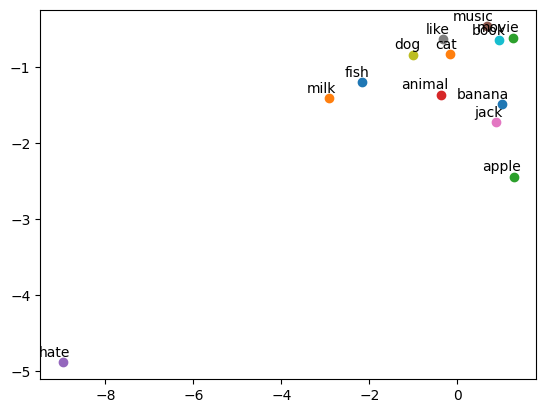

In [12]:
import matplotlib.pyplot as plt

for i, label in enumerate(vocab):
    W, WT = model.parameters()
    x, y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()